In [2]:

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torchvision
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.decomposition import PCA, KernelPCA
from timm import create_model
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import cv2

In [3]:
# Data augmentation and normalization for training
data_transforms = {
 'train': transforms.Compose([
 transforms.RandomResizedCrop(224),
 transforms.RandomHorizontalFlip(),
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ]),
 'val': transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ]),
}


batch_size = 4
data_dir = './datasets/100sportClassification'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
 shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [5]:
def set_parameter_requires_grad(model, feature_extracting=False):
    if feature_extracting:
    # frozen model
        model.requires_grad_(False)
    else:
    # fine-tuning
        model.requires_grad_(True)


In [6]:
#!git clone https://github.com/hila-chefer/Transformer-Explainability.git
#!pip install einops
os.chdir(f'./Transformer-Explainability')

import baselines.ViT.ViT_new
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

In [7]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 224 # image size, e.g. (3, 224, 224)
    model_ft=vit_LRP(pretrained=True).cuda()
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.head.in_features
    model_ft.head = nn.Linear(num_ftrs, num_classes)  # Replace the head for classification

    return model_ft, input_size

In [8]:
os.chdir(f'..')

In [9]:

#hyperparameters
num_classes = 100
batch_size = 8
num_epochs = 5
# Flag for feature extracting. When False, we fine-tune the whole model.
feature_extract = True


In [10]:
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
# Print the model, before dora
print(model_ft)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=100, bia

In [11]:
#finetuning with Lora/Dora
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        self.use_dora = use_dora
        self.rank = rank  # low-rank
        self.alpha = alpha  # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))
        
        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T 
            return F.linear(x, combined_weight, self.linear.bias)

In [12]:
rank = 4
alpha = 8
model_ft.blocks[9].mlp.fc1 = LowRankLayer(model_ft.blocks[9].mlp.fc1, rank, alpha, use_dora=True)
# Print the model we just instantiated, including dora
print(model_ft)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-8): 9 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (9): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): 

In [13]:
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = [] # override the initial list definition above
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:
	 blocks.9.mlp.fc1.A
	 blocks.9.mlp.fc1.B
	 blocks.9.mlp.fc1.m
	 head.weight
	 head.bias


In [14]:
"""
Training function
"""
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [20]:
criterion = nn.CrossEntropyLoss()
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 1.0600 Acc: 0.7408
val Loss: 0.2444 Acc: 0.9360

Epoch 1/4
----------
train Loss: 0.5536 Acc: 0.8491
val Loss: 0.1685 Acc: 0.9560

Epoch 2/4
----------
train Loss: 0.4494 Acc: 0.8765
val Loss: 0.1248 Acc: 0.9680

Epoch 3/4
----------
train Loss: 0.3764 Acc: 0.8949
val Loss: 0.1092 Acc: 0.9720

Epoch 4/4
----------
train Loss: 0.3608 Acc: 0.9012
val Loss: 0.1100 Acc: 0.9680

Training complete in 6m 54s
Best val Acc: 0.972000


In [15]:
#torch.save(model_ft.state_dict(), './vit_new_weights_Dora.pth')
model_ft.load_state_dict(torch.load('./vit_new_weights_Dora.pth'))

/tmp/ipykernel_946122/370434687.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('./vit_new_weights_Dora.pth'))


<All keys matched successfully>

In [16]:
os.chdir(f'./Transformer-Explainability')

In [17]:
CLS2IDX = {
    0: 'air hockey',
    1: 'ampute football',
    2: 'archery',
    3: 'arm wrestling',
    4: 'axe throwing',
    5: 'balance beam',
    6: 'barell racing',
    7: 'baseball',
    8: 'basketball',
    9: 'baton twirling',
    10: 'bike polo',
    11: 'billiards',
    12: 'bmx',
    13: 'bobsled',
    14: 'bowling',
    15: 'boxing',
    16: 'bull riding',
    17: 'bungee jumping',
    18: 'canoe slamon',
    19: 'cheerleading',
    20: 'chuckwagon racing',
    21: 'cricket',
    22: 'croquet',
    23: 'curling',
    24: 'disc golf',
    25: 'fencing',
    26: 'field hockey',
    27: 'figure skating men',
    28: 'figure skating pairs',
    29: 'figure skating women',
    30: 'fly fishing',
    31: 'football',
    32: 'formula 1 racing',
    33: 'frisbee',
    34: 'gaga',
    35: 'giant slalom',
    36: 'golf',
    37: 'hammer throw',
    38: 'hang gliding',
    39: 'harness racing',
    40: 'high jump',
    41: 'hockey',
    42: 'horse jumping',
    43: 'horse racing',
    44: 'horseshoe pitching',
    45: 'hurdles',
    46: 'hydroplane racing',
    47: 'ice climbing',
    48: 'ice yachting',
    49: 'jai alai',
    50: 'javelin',
    51: 'jousting',
    52: 'judo',
    53: 'lacrosse',
    54: 'log rolling',
    55: 'luge',
    56: 'motorcycle racing',
    57: 'mushing',
    58: 'nascar racing',
    59: 'olympic wrestling',
    60: 'parallel bar',
    61: 'pole climbing',
    62: 'pole dancing',
    63: 'pole vault',
    64: 'polo',
    65: 'pommel horse',
    66: 'rings',
    67: 'rock climbing',
    68: 'roller derby',
    69: 'rollerblade racing',
    70: 'rowing',
    71: 'rugby',
    72: 'sailboat racing',
    73: 'shot put',
    74: 'shuffleboard',
    75: 'sidecar racing',
    76: 'ski jumping',
    77: 'sky surfing',
    78: 'skydiving',
    79: 'snow boarding',
    80: 'snowmobile racing',
    81: 'speed skating',
    82: 'steer wrestling',
    83: 'sumo wrestling',
    84: 'surfing',
    85: 'swimming',
    86: 'table tennis',
    87: 'tennis',
    88: 'track bicycle',
    89: 'trapeze',
    90: 'tug of war',
    91: 'ultimate',
    92: 'uneven bars',
    93: 'volleyball',
    94: 'water cycling',
    95: 'water polo',
    96: 'weightlifting',
    97: 'wheelchair basketball',
    98: 'wheelchair racing',
    99: 'wingsuit flying'}

In [18]:
start_layer = 0

def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition

def generate_relevance(model, input, index=None):
    output = model(input, register_hook=True)
    if index == None:
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    num_tokens = model.blocks[0].attn.get_attention_map().shape[-1]
    R = torch.eye(num_tokens, num_tokens).cuda()
    for i,blk in enumerate(model.blocks):
        if i < start_layer:
            continue
        grad = blk.attn.get_attn_gradients()
        cam = blk.attn.get_attention_map()
        cam = avg_heads(cam, grad)
        R += apply_self_attention_rules(R.cuda(), cam.cuda())
    return R[0, 1:]

In [19]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(model, original_image, class_index=None):
    with torch.enable_grad():
        transformer_attribution = generate_relevance(model, original_image.unsqueeze(0).cuda(), index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Top 5 classes:
	8 : basketball           		value = 15.000	 prob = 95.7%
	97 : wheelchair basketball		value = 11.849	 prob = 4.1%
	71 : rugby                		value = 8.571	 prob = 0.2%
	31 : football             		value = 6.454	 prob = 0.0%
	59 : olympic wrestling    		value = 5.984	 prob = 0.0%


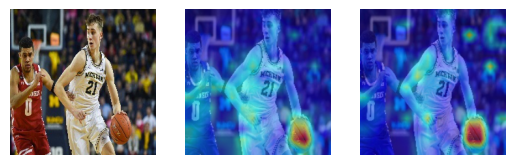

In [20]:
#swimming Vs basketball
model=model_ft
model.requires_grad_(True)
image = Image.open('../datasets/100sportClassification/val/basketball/1.jpg')
basketball_image = data_transforms['val'](image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(basketball_image.unsqueeze(0).cuda())
print_top_classes(output)

# basketball - the predicted class
basketball = generate_visualization(model,basketball_image)

# swimming 
# generate visualization for class 85: 'swimming'
swimming = generate_visualization(model,basketball_image, class_index=85)


axs[1].imshow(basketball);
axs[1].axis('off');
axs[2].imshow(swimming);
axs[2].axis('off');

Top 5 classes:
	85 : swimming     		value = 11.074	 prob = 56.6%
	95 : water polo   		value = 10.759	 prob = 41.3%
	54 : log rolling  		value = 6.943	 prob = 0.9%
	94 : water cycling		value = 6.518	 prob = 0.6%
	84 : surfing      		value = 5.216	 prob = 0.2%


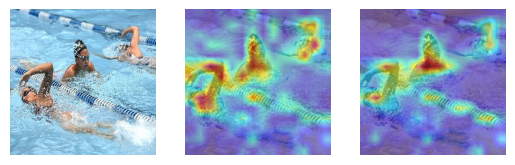

In [21]:
#swimming Vs basketball
image = Image.open('../datasets/100sportClassification/val/swimming/3.jpg')
swimming_image = data_transforms['val'](image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(swimming_image.unsqueeze(0).cuda())
print_top_classes(output)

# swimming - the predicted class
swimming = generate_visualization(model,swimming_image)

# basketball 
# generate visualization for class 8: 'basketball'
basketball = generate_visualization(model,swimming_image, class_index=8)


axs[1].imshow(swimming);
axs[1].axis('off');
axs[2].imshow(basketball);
axs[2].axis('off');

Top 5 classes:
	87 : tennis      		value = 14.292	 prob = 99.9%
	86 : table tennis		value = 7.358	 prob = 0.1%
	66 : rings       		value = 5.544	 prob = 0.0%
	53 : lacrosse    		value = 4.252	 prob = 0.0%
	33 : frisbee     		value = 3.877	 prob = 0.0%


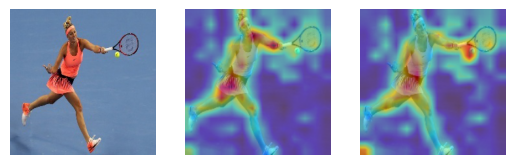

In [22]:
#tennis Vs boxing
image = Image.open('../datasets/100sportClassification/val/tennis/3.jpg')
tennis_image = data_transforms['val'](image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tennis_image.unsqueeze(0).cuda())
print_top_classes(output)

# tennis - the predicted class
tennis = generate_visualization(model,tennis_image)

# boxing 
# generate visualization for class 15: 'boxing'
boxing = generate_visualization(model,tennis_image, class_index=15)


axs[1].imshow(tennis);
axs[1].axis('off');
axs[2].imshow(boxing);
axs[2].axis('off');

Top 5 classes:
	15 : boxing           		value = 15.035	 prob = 100.0%
	73 : shot put         		value = 6.218	 prob = 0.0%
	59 : olympic wrestling		value = 5.539	 prob = 0.0%
	25 : fencing          		value = 4.663	 prob = 0.0%
	71 : rugby            		value = 4.584	 prob = 0.0%


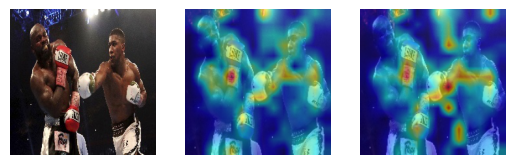

In [23]:
#tennis Vs boxing
image = Image.open('../datasets/100sportClassification/val/boxing/5.jpg')
boxing_image = data_transforms['val'](image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(boxing_image.unsqueeze(0).cuda())
print_top_classes(output)

# boxing - the predicted class
boxing = generate_visualization(model,boxing_image)

# tennis 
# generate visualization for class 87: 'tennis'
tennis = generate_visualization(model,boxing_image, class_index=87)


axs[1].imshow(boxing);
axs[1].axis('off');
axs[2].imshow(tennis);
axs[2].axis('off');